## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error

2024-10-28 17:04:09.864706: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 17:04:09.868539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-28 17:04:09.868553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Caminhos utilizados no fluxo

In [2]:
input_path = '/home/murilo/workspace/tcc/tcc/python_model/database/x_test.csv'
output_path = '/home/murilo/workspace/tcc/tcc/python_model/database/y_test.csv'
modelos_micro_folder = '/home/murilo/workspace/tcc/tcc/python_model/src/modelos_micro/'

model_paths = {
    'Inteiro completo': modelos_micro_folder + 'model_full_integer_quantized.tflite',
    'Apenas pesos': modelos_micro_folder + 'model_weights_only_quantized.tflite',
    'Faixa dinâmica': modelos_micro_folder + 'model_dynamic_range_quantized.tflite',
    'Float 16' : modelos_micro_folder + 'model_float16_quantized.tflite',
    'Float32': modelos_micro_folder + 'model_float32.tflite',
    'Keras' : 'mlp_model.h5',
}

2024-10-28 17:04:12.145147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-10-28 17:04:12.145179: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-28 17:04:12.145191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (murilo): /proc/driver/nvidia/version does not exist
2024-10-28 17:04:12.145430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


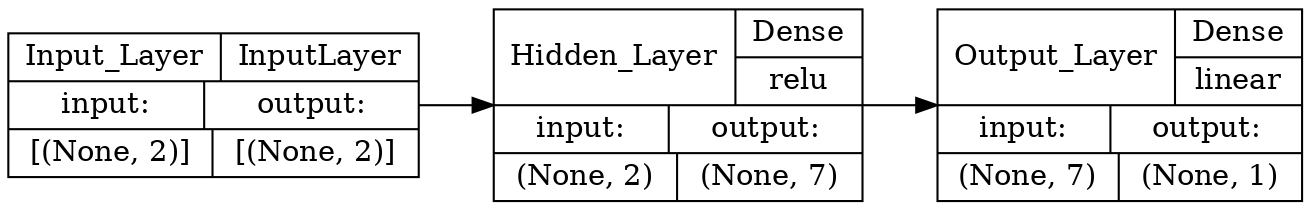

In [3]:
model_py = tf.keras.models.load_model(f"mlp_model.h5")

keras.utils.plot_model(
    model_py,
    "/home/murilo/workspace/tcc/tcc/python_model/images/mlp_model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=150,
    show_layer_activations=True,
    rankdir="LR"
)

## Base de dados para teste

In [4]:
def desnormalize(value, mean, scale):
    value = value * scale + mean                        
    return np.expm1(value)

mean_sodio, scale_sodio = 2.0841135541357527, 0.54462804093762
mean_potassio, scale_potassio = 1.5888672049282762, 0.47844564993241423
mean_cloro, scale_cloro = 2.7378255142446153, 0.504330768563497

In [5]:
x_test = pd.read_csv(input_path).to_numpy()
y_test = pd.read_csv(output_path).to_numpy()

## Volumentria dos arquivos

In [6]:
model_sizes = {name: os.path.getsize(path) for name, path in model_paths.items()}
model_sizes = dict(sorted(model_sizes.items(), key=lambda item: item[1], reverse=True))
model_sizes

{'Keras': 27136,
 'Float 16': 2372,
 'Inteiro completo': 1912,
 'Apenas pesos': 1716,
 'Faixa dinâmica': 1716,
 'Float32': 1712}

In [7]:
data = pd.DataFrame(list(model_sizes.items()), columns=['Model', 'Size (Bytes)'])
data['Size (KB)'] = data['Size (Bytes)'] / 1024
data['Reduction (%)'] = 100 - (data['Size (KB)'] / data['Size (KB)'].iloc[0] * 100)

fig, ax1 = plt.subplots(figsize=(14, 8))
palette = sns.color_palette("viridis", len(data))
bars = sns.barplot(x='Model', y='Size (KB)', data=data, ax=ax1, palette=palette, edgecolor='black')

ax1.set_xlabel('Modelos', fontsize=23, color='black')
ax1.set_ylabel('Tamanho em kB', fontsize=23, color='black')
ax1.tick_params(axis='y', labelsize=13, labelcolor='black')
ax1.tick_params(axis='x', labelsize=13, labelcolor='black')
ax1.set_title('Comparação entre Modelos e Redução de Tamanho', fontsize=23, color='black')


ax1.set_ylim(0, data['Size (KB)'].max() * 1.2) 

for index, value in enumerate(data['Size (KB)']):
    ax1.text(index, value + 2, f"{value:.2f} KB", ha='center', va='bottom', color='black', fontsize=13)

ax2 = ax1.twinx()
ax2.plot(data['Model'], data['Reduction (%)'], color='#ff7f0e', marker='o', linewidth=2)
ax2.fill_between(data['Model'], data['Reduction (%)'], color='#ffbb78', alpha=0.3)

ax2.set_ylabel('Redução (%)', fontsize=23, color='black')
ax2.tick_params(axis='y', labelsize=13, labelcolor='black')

ax2.set_ylim(0, max(data['Reduction (%)']) * 1.2)

for index, value in enumerate(data['Reduction (%)']):
    ax2.text(index, value + 2, f"{value:.2f}%", ha='center', va='bottom', color='#ff7f0e', fontsize=13)

ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

fig.tight_layout()
plt.savefig("/home/murilo/workspace/tcc/tcc/python_model/images/comparativo_volume.png")
plt.close()

/tmp/ipykernel_388604/2455330540.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Model', y='Size (KB)', data=data, ax=ax1, palette=palette, edgecolor='black')


## Carregando os modelos

### Modelos TFlite

In [8]:
models = {
    'Inteiro completo': modelos_micro_folder + 'model_full_integer_quantized.tflite',
    'Apenas pesos': modelos_micro_folder + 'model_weights_only_quantized.tflite',
    'Faixa dinâmica': modelos_micro_folder + 'model_dynamic_range_quantized.tflite',
    'Float 16' : modelos_micro_folder + 'model_float16_quantized.tflite',
    'Float 32': modelos_micro_folder + 'model_float32.tflite',
}

interpreters = {}
for key, path in models.items():
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    interpreters[key] = interpreter

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Modelo Keras

In [9]:
interpreters['Keras'] = tf.keras.models.load_model("mlp_model.h5")

In [10]:
interpreters

{'Inteiro completo': <tensorflow.lite.python.interpreter.Interpreter at 0x7e9e06ba7c10>,
 'Apenas pesos': <tensorflow.lite.python.interpreter.Interpreter at 0x7e9e075b41f0>,
 'Faixa dinâmica': <tensorflow.lite.python.interpreter.Interpreter at 0x7e9e075b7c40>,
 'Float 16': <tensorflow.lite.python.interpreter.Interpreter at 0x7e9e075b7bb0>,
 'Float 32': <tensorflow.lite.python.interpreter.Interpreter at 0x7e9e075b7b20>,
 'Keras': <keras.engine.functional.Functional at 0x7e9e0758b850>}

## Tempo de execução

In [11]:
def predict_tflite(model, test_data):
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    predictions = []

    input_type = input_details[0]['dtype']

    for example in test_data:
        test_example = np.expand_dims(example, axis=0).astype(input_type)
        model.set_tensor(input_details[0]['index'], test_example)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
        
    return np.array(predictions)

inference_times = {name: [] for name in interpreters}
inferences = {name: [] for name in interpreters}

for name, model in interpreters.items():
    for _ in range(100):
        start_time = time.time()
        if name != 'Keras':
            predictions = predict_tflite(model, x_test)
        else:
            predictions = model.predict(x_test)
        end_time = time.time()
        inference_times[name].append(end_time - start_time)

2/2 [==============================] - 0s 2ms/step


In [12]:
results_file = "/home/murilo/workspace/tcc/tcc/python_model/results/inference_times_results.txt"

with open(results_file, 'w') as f:
    for name, times in inference_times.items():
        f.write(f"{name}:\n")
        f.write(f"  Média do Tempo de Inferência: {np.mean(times):.4f} segundos\n")
        f.write(f"  Mediana do Tempo de Inferência: {np.median(times):.4f} segundos\n")
        f.write(f"  Desvio Padrão: {np.std(times):.4f} segundos\n")
        f.write(f"  Máximo: {np.max(times):.4f} segundos\n")
        f.write(f"  Mínimo: {np.min(times):.4f} segundos\n")
        f.write("\n")
print(f"Tempos de inferência salvos em {results_file}")

Tempos de inferência salvos em /home/murilo/workspace/tcc/tcc/python_model/results/inference_times_results.txt


## Métricas de erro

In [13]:
def predict_tflite(model, test_data):
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    predictions = []

    input_type = input_details[0]['dtype']
    
    for example in test_data:
        test_example = np.expand_dims(example, axis=0).astype(input_type)
        model.set_tensor(input_details[0]['index'], test_example)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0][0])
    return np.array(predictions)

predictions_dict = {}
for name, model in interpreters.items():
    if name != 'Keras':
        predictions_dict[name] = predict_tflite(model, x_test)
    else:
        predictions_dict[name] = model.predict(x_test).flatten()

2/2 [==============================] - 0s 2ms/step


In [14]:
metrics_dict = {}

for name, predictions in predictions_dict.items():
    start_time = time.time()
    
    y_test_denorm = desnormalize(y_test, mean_cloro, scale_cloro)
    predictions_denorm = desnormalize(predictions, mean_cloro, scale_cloro)
    
    mse = mean_squared_error(y_test_denorm, predictions_denorm)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_denorm, predictions_denorm)
    r2 = r2_score(y_test_denorm, predictions_denorm)
    medae = median_absolute_error(y_test_denorm, predictions_denorm)
    mape = mean_absolute_percentage_error(y_test_denorm, predictions_denorm)
    
    end_time = time.time()
    exec_time = end_time - start_time

    metrics_dict[name] = {
        'MSE': mse,
        'RMSE': rmse, 
        'MAE': mae,
        'R2': r2,
        'MEDAE': medae,
        'MAPE': mape,
        'Execution Time (s)': exec_time
    }


with open('/home/murilo/workspace/tcc/tcc/python_model/results/metrics_results.txt', 'w') as f:
    for name, metrics in metrics_dict.items():
        f.write(f"Resultados para o modelo {name}:\n")
        for metric, value in metrics.items():
            f.write(f"  {metric}: {value:.5f}\n")
        f.write("\n")

## Previsões dos modelos quantizados

In [23]:
save_dir = "/home/murilo/workspace/tcc/tcc/python_model/images/"

y_test_denorm = desnormalize(y_test, mean_cloro, scale_cloro)

predictions_denorm = desnormalize(predictions_dict['Keras'], mean_cloro, scale_cloro)
plt.figure(figsize=(7, 7))
plt.scatter(y_test_denorm, predictions_denorm, color='blue', alpha=0.5, label='Previsões Keras')
plt.plot([min(y_test_denorm), max(y_test_denorm)], [min(y_test_denorm), max(y_test_denorm)], 'k--', label='Linha Ideal')
plt.xlabel('Valores Reais', fontsize=18)
plt.ylabel('Valores Preditos', fontsize=18)
plt.grid()
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(save_dir, "keras_predictions.png"), bbox_inches='tight')
plt.close()

model_names = [name for name in predictions_dict if name != 'Keras']

for name in model_names:
    predictions_denorm = desnormalize(predictions_dict[name], mean_cloro, scale_cloro)
    plt.figure(figsize=(7, 7))
    plt.scatter(y_test_denorm, predictions_denorm, color='red', alpha=0.5, label=f'Previsões {name}')
    plt.plot([min(y_test_denorm), max(y_test_denorm)], [min(y_test_denorm), max(y_test_denorm)], 'k--', label='Linha Ideal')
    plt.xlabel('Valores Reais', fontsize=18)
    plt.ylabel('Valores Preditos', fontsize=18)
    plt.grid()
    plt.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(os.path.join(save_dir, f"{name}_predictions.png"), bbox_inches='tight')
    plt.close()

## RESULTADOS NO MICRO CONTROLADOR

In [16]:
# valores_saida = pd.read_csv('/home/murilo/workspace/tcc/tcc/utils/valores_saida.csv')
# saida = pd.read_csv('/home/murilo/workspace/tcc/tcc/python_model/database/saida.csv')

# predicted_cl = valores_saida['Cl']
# real_cl = saida['Cl']

# # Atualizando o gráfico com as alterações solicitadas
# plt.figure(figsize=(7, 7))  # Mantendo o tamanho do gráfico em 7x7
# plt.scatter(real_cl, predicted_cl, color='green', alpha=0.5, label='Previsões ESP32', marker='o')
# plt.plot([real_cl.min(), real_cl.max()], [real_cl.min(), real_cl.max()], 'k--', label='Linha Ideal')
# plt.title('Modelo ESP32')
# plt.xlabel('Valores Reais')
# plt.ylabel('Valores Preditos')
# plt.grid(True)  # Ativação da grade no gráfico
# plt.legend()
# plt.show()

In [17]:
# consumo_df = pd.read_csv('/home/murilo/workspace/tcc/tcc/utils/consumo.csv')
# consumo_df_filtered = consumo_df.iloc[87951:].reset_index(drop=True)

# consumo_df_filtered['Corrente(A)'] = consumo_df_filtered['Current(uA)'] / 1000000
# consumption_stats_filtered = consumo_df_filtered['Corrente(A)'].agg(['min', 'max', 'mean'])

# consumo_df_filtered['Adjusted Time(s)'] = (consumo_df_filtered['Timestamp(ms)'] - 879.51) / 1000

# plt.figure(figsize=(14, 7))
# plt.plot(consumo_df_filtered['Adjusted Time(s)'], consumo_df_filtered['Corrente(A)'], label='Corrente (A)')
# plt.title('Consumo de Corrente ao Longo do Tempo')
# plt.xlabel('Tempo (s)')
# plt.ylabel('Corrente (A)')
# plt.legend()
# plt.grid(True)
# plt.show()

## Detalhe do modelo Float 32

In [20]:
model = interpreters['Float 32']

input_details = model.get_input_details()
print("Detalhes do Tensor de Entrada:", input_details)

output_details = model.get_output_details()
print("Detalhes do Tensor de Saída:", output_details)

Detalhes do Tensor de Entrada: [{'name': 'serving_default_Input_Layer:0', 'index': 0, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalhes do Tensor de Saída: [{'name': 'StatefulPartitionedCall:0', 'index': 6, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## Criação do array de bytes para o Embarque na ESP32

In [21]:
tflite_model_file = '/home/murilo/workspace/tcc/tcc/python_model/src/modelos_micro/model_float32.tflite'

# Conteúdo do arquivo model.h
header_content = """
#ifndef MODEL_H_
#define MODEL_H_

extern const unsigned char model[];
extern const int model_len;

#endif  // MODEL_H_
"""

# Escreve o conteúdo no arquivo model.h
with open("model.h", "w") as file:
    file.write(header_content.strip())

with open(tflite_model_file, 'rb') as f:
    tflite_model_content = f.read()

with open("model.cc", "w") as f:
    f.write("const unsigned char model[] = {\n    ")
    for i, byte in enumerate(tflite_model_content):
        f.write(f"0x{byte:02x}, ")
        if (i + 1) % 12 == 0:
            f.write("\n    ")
    f.write("\n};\n")
    f.write(f"const int model_len = {len(tflite_model_content)};")